Этот ноутбук - попытка осуществить автоматическую разметку фаз удара на основе характерных признаков.
Практика показала, что данный код дает приемлемые результаты для видео снятых с боку. Однако, для видео снятых фронтально результаты оказались неудовлетворительными.
В итоге, метод был признан тупиковым, датасет размечен вручную.

Ссылка на колаб:  https://colab.research.google.com/drive/1gf0lbqRTptZzmfysdOvd51YA_kS7j7s2?usp=sharing


#Начальные установки и загрузка

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import sys
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
from scipy.signal import find_peaks_cwt

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(linewidth=45)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/internship/karate/dataset'
filename = 'dataset__all_features.csv'   # здесь нужно указать название обрабатываемого файла
df = pd.read_csv(os.path.join(data_path,filename))

In [4]:
df

,0,1,2,3,4,5,6,7,8,9,...,o24_26_OZ,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ
0,0,0,0,0,0,0,0,0,0,1,...,-0.320266,0.925819,0.330658,-0.183095,0.842526,-0.251213,0.476489,0.787591,0.045598,0.614508
1,0,0,0,0,0,0,0,0,0,1,...,-0.358186,0.908620,0.318595,-0.270015,0.847875,-0.252573,0.466171,0.856474,0.052875,0.513474
2,0,0,0,0,0,0,0,0,0,1,...,-0.392047,0.820056,0.288839,-0.494045,0.831219,-0.246556,0.498283,0.849801,0.051036,0.524627
3,0,0,0,0,0,0,0,0,0,1,...,-0.386496,0.842421,0.290291,-0.453936,0.830638,-0.245556,0.499743,0.846481,0.050976,0.529973
4,0,0,0,0,0,0,0,0,0,1,...,-0.390121,0.822300,0.278694,-0.496137,0.847154,-0.250359,0.468669,0.868949,0.052760,0.492081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142363,0,0,1,0,0,0,0,0,0,0,...,-0.455400,0.698299,0.489481,-0.522291,0.552038,-0.363697,0.750319,0.636238,-0.042069,0.770345
142364,0,0,1,0,0,0,0,0,0,0,...,-0.447005,0.704808,0.496040,-0.507139,0.534342,-0.367378,0.761257,0.638538,-0.042032,0.768442
142365,0,0,1,0,0,0,0,0,0,0,...,-0.453217,0.770869,0.539021,-0.339435,0.557973,-0.401605,0.726209,0.648042,-0.042260,0.760431
142366,0,0,1,0,0,0,0,0,0,0,...,-0.455419,0.771385,0.555455,-0.310540,0.563317,-0.430092,0.705475,0.653394,-0.044460,0.755711


In [5]:
#Проверим существование столбца для сохранения фаз, если отсутствует, то добавим
if 'phase' not in df.columns:
  df['phase']=np.zeros_like(len(df))
df

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
0,0,0,0,0,0,0,0,0,0,1,...,0.925819,0.330658,-0.183095,0.842526,-0.251213,0.476489,0.787591,0.045598,0.614508,0
1,0,0,0,0,0,0,0,0,0,1,...,0.908620,0.318595,-0.270015,0.847875,-0.252573,0.466171,0.856474,0.052875,0.513474,0
2,0,0,0,0,0,0,0,0,0,1,...,0.820056,0.288839,-0.494045,0.831219,-0.246556,0.498283,0.849801,0.051036,0.524627,0
3,0,0,0,0,0,0,0,0,0,1,...,0.842421,0.290291,-0.453936,0.830638,-0.245556,0.499743,0.846481,0.050976,0.529973,0
4,0,0,0,0,0,0,0,0,0,1,...,0.822300,0.278694,-0.496137,0.847154,-0.250359,0.468669,0.868949,0.052760,0.492081,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142363,0,0,1,0,0,0,0,0,0,0,...,0.698299,0.489481,-0.522291,0.552038,-0.363697,0.750319,0.636238,-0.042069,0.770345,0
142364,0,0,1,0,0,0,0,0,0,0,...,0.704808,0.496040,-0.507139,0.534342,-0.367378,0.761257,0.638538,-0.042032,0.768442,0
142365,0,0,1,0,0,0,0,0,0,0,...,0.770869,0.539021,-0.339435,0.557973,-0.401605,0.726209,0.648042,-0.042260,0.760431,0
142366,0,0,1,0,0,0,0,0,0,0,...,0.771385,0.555455,-0.310540,0.563317,-0.430092,0.705475,0.653394,-0.044460,0.755711,0


#Основные настройки

In [6]:
n_angles=8 #количество углов для анализа неподвижности
# Ширина скользящего окна
angle_window_width = 8
speed_window_width = 20
DisplaySkipFrame=10

#Возможные состояния
STATUS_STANCE=1
STATUS_KICK=2
STATUS_RET=3

statuses={
    STATUS_STANCE:'STANCE',
    STATUS_KICK:'KICK',
    STATUS_RET:'RETURN'
}

In [7]:
angles_dict={
    'a12_14_16': 'угол в правом локтевом суставе',
    'a11_13_15': 'угол в левом локтевом суставе',
    'a14_12_24': 'угол в правом плечевом суставе (вертикально)',
    'a13_11_23': 'угол в левом плечевом суставе (вертикально)',
    'a14_12_11': 'угол в правом плечевом суставе (горизонтально)',
    'a13_11_12': 'угол в левом плечевом суставе (горизонтально)',
    'a24_26_28': 'угол в правом коленном суставе',
    'a23_25_27': 'угол в левом коленном суставе',
    'a12_24_26': 'угол в правом тазобедренном суставе',
    'a11_23_25': 'угол в левом тазобедренном суставе',
    'a25_27_31': 'угол в левой стопе',
    'a26_28_32': 'угол в правой стопе',
    'a23_11_7':  'угол между линиями правые бедро-плечо-ухо',
    'a24_12_8' : 'угол между линиями левые бедро-плечо-ухо',
    'g12_11_28_27' : 'угол между линией плеч и линией щиколоток',
    'g12_11_24_23' : 'угол между линией плеч и линией таза',
    'g12_11_26_25' : 'угол между линией плеч и линией колен',
    'g12_11_14_13' : 'угол между линией плеч и линией локтей',
    'g12_11_16_15' : 'угол между линией плеч и линией запястий',
    'g14_16_13_15' : 'угол между линией локоть-запястье правой руки и левой руки',
    'g12_14_11_13' : 'угол между линией плечо-локоть правой руки и левой руки',
    'g24_26_23_25' : 'угол между линией бедро-колено правой ноги и левой ноги',
    'g26_28_25_27' : 'угол между линией колено-щиколотка правой ноги и левой ноги',
    'o12_14_OY' : 'угол между линия плечо-локоть правой руки и OY',
    'o12_14_OX' : 'угол между линия плечо-локоть правой руки и OX',
    'o12_14_OZ' : 'угол между линия плечо-локоть правой руки и OZ',
    'o11_13_OY' : 'угол между линия плечо-локоть левой руки и OY',
    'o11_13_OX' : 'угол между линия плечо-локоть левой руки и OX',
    'o11_13_OZ' : 'угол между линия плечо-локоть левой руки и OZ',
    'o14_16_OY' : 'угол между линия локоть-запястье правой руки и OY',
    'o14_16_OX' : 'угол между линия локоть-запястье правой руки и OX',
    'o14_16_OZ' : 'угол между линия локоть-запястье правой руки и OZ',
    'o13_15_OY' : 'угол между линия локоть-запястье левой руки и OY',
    'o13_15_OX' : 'угол между линия локоть-запястье левой руки и OX',
    'o13_15_OZ' : 'угол между линия локоть-запястье левой руки и OZ',
    'o24_26_OY' : 'угол между линия бедро-колено правой ноги и OY',
    'o24_26_OX' : 'угол между линия бедро-колено правой ноги и OX',
    'o24_26_OZ' : 'угол между линия бедро-колено правой ноги и OZ',
    'o23_25_OY' : 'угол между линия бедро-колено левой ноги и OY',
    'o23_25_OX' : 'угол между линия бедро-колено левой ноги и OX',
    'o23_25_OZ' : 'угол между линия бедро-колено левой ноги и OZ',
    'o26_28_OY' : 'угол между линия колено-щиколотка правой ноги и OY',
    'o26_28_OX' : 'угол между линия колено-щиколотка правой ноги и OX',
    'o26_28_OZ' : 'угол между линия колено-щиколотка правой ноги и OZ',
    'o25_27_OY' : 'угол между линия колено-щиколотка левой ноги и OY',
    'o25_27_OX' : 'угол между линия колено-щиколотка левой ноги и OX',
    'o25_27_OZ' : 'угол между линия колено-щиколотка левой ноги и OZ'
}

#Основные функции

##Подготовка датасета конкрентного видео

In [8]:
# Функция для применения скользящего окна при сглаживании
def smooth_data(data, window_width):
    smoothed_data = np.convolve(data, np.ones(window_width) / window_width, mode='same')
    return smoothed_data

In [9]:
def get_video_df(df,file_name,reference_angles):
  '''
  Подготавливает и Возвращает датафрейм с данными только для конкретного видео
  df - основной датафрейм
  file_name - имя видеофайла
  reference_angels - список углов для отслеживания
  '''
  #получаем только данные для нужного видео
  df1=df[df['filename']==file_name]
  #сформируем датасет в котором есть только cos углов (их имена начинаются на 'a','g','o')
  column_list=list(df)
  angle_column_list=[x for x in column_list if x.startswith(('a','g','o'))]
  df_cos_angles=df1[angle_column_list]

  #Найдем n_angles углов, для которых изменения во время удара наиболее значительны
  df_angles=pd.DataFrame(np.arccos(df_cos_angles)*180/np.pi) # перевели в градусы (так нагляднее)
  df_angles_change=np.max(df_angles,axis=0)-np.min(df_angles,axis=0) #Получили series с данными на сколько изменяеется тот или иной угол

  #отсоритирум колонки по значению изменений
  sorted_column=df_angles_change.sort_values(ascending=False).index #Отсортировали колонки в порядке убывания
  main_angles=list(sorted_column)[:n_angles] #Список самых значмиых углов. Теперь именно эти углы будем анализировать
  for col in main_angles:
    print (f'Угол {angles_dict[col]} ({col}) изменяется на {df_angles_change[col]:4.2f} градусов')

  #проверим, что колонки из reference_angles входят в список main_angles, Если нет, то добавим их
  for angle in reference_angles:
    if angle not in main_angles:
      main_angles.append(angle)

  #Сделаем датафрейм, который содержит только самые значимые углы и углы из reference_angles
  df_angles=df_angles[main_angles]

  #Получим для каждого кадра (начиная со второго) значение изменения угла в градусах от кадра к кадру (фактически скорость)
  speeds=df_angles[1:].values-df_angles[:-1].values
  speeds=np.vstack((np.zeros(shape=len(main_angles)),speeds))#Будем считать что для первого кадра скорость =0
  speed_column_list=[x+'_speed' for x in list(df_angles)]
  df_speed=pd.DataFrame(speeds,columns=speed_column_list)

  #Объединим датасет с углами с датасетом скоростей
  df_speed.index=df_angles.index #привели индексы
  df_all=pd.concat([df_angles,df_speed], axis=1)

  #создадим колонки со сглаженными данными
  for col in list(df_all):
    if col.find("speed")>=0:
      df_all[col+'_sm']=smooth_data(df_all[col],speed_window_width)
    else:
      df_all[col+'_sm']=smooth_data(df_all[col],angle_window_width)

  #Получим среднее значение модулей скорости для каждого кадра (значение будет низкое если человек не двигается и высокое исли есть движение)
  #пробовал не использовать этот параметр,но выяснилось, что стойка лучше всего определяется именно по нему, а не по скорости изменения референсных углов
  avg_speed=np.mean(np.abs(df_speed),axis=1)
  avg_speed=avg_speed/np.max(avg_speed)#  нормировка 0-1
  avg_speed_smoothed = smooth_data(avg_speed, speed_window_width)
  df_all['avg_speed']=avg_speed
  df_all['avg_speed_sm']=avg_speed_smoothed
  return df_all


#Анализ данных и Вывод графиков

In [10]:
#функция для вывода графиков определенного угла
def show_charts(df_all, angle_name,mode='all', show_avg_speed=True):
  nrows=2
  if show_avg_speed:
    nrows=3
  fig,axs=plt.subplots(nrows=nrows,ncols=1,figsize=(30,16))
  if mode=='all' or mode=='orig':
    axs[0].plot(df_all[angle_name],label=f'график угла {angle_name} ({angles_dict[angle_name]})')
  if mode=='all' or mode=='smoot':
    axs[0].plot(df_all[angle_name+'_sm'],label=f'сглаженный график угла {angle_name} ({angles_dict[angle_name]})')
  axs[0].grid(True)
  axs[0].legend()
  if mode=='all' or mode=='orig':
    axs[1].plot(df_all[angle_name+'_speed'],label=f'график скорости изменения угла {angle_name} ({angles_dict[angle_name]})')
  if mode=='all' or mode=='smoot':
    axs[1].plot(df_all[angle_name+'_speed_sm'],label=f'сглаженный график скорости изменения угла {angle_name} ({angles_dict[angle_name]})')
  axs[1].legend()
  axs[1].grid(True)
  if show_avg_speed:
    if mode=='all' or mode=='orig':
      axs[2].plot(df_all['avg_speed'],label=f'график средней скорости изменения основных углов')
    if mode=='all' or mode=='smoot':
      axs[2].plot(df_all['avg_speed_sm'],label=f'сглаженный график средней скорости изменения основных углов')
    axs[2].legend()
    axs[2].grid(True)
  plt.show()

In [11]:
def get_MaxMin(data, dist=5, find_min= False, show_info=False):
  '''
  Ищет минимумы в графике, находит максимальный из них
  data - входные данные
  dist - минимальная дистанция между пиками
  find_min - Если True, график переворачивается и ищутся минимумы
  show_info - печатать или не печатать найденые значения, выводить или не выводить график (для отладки)
  '''
  temp_data=data.copy()
  if find_min:
    temp_data=temp_data*-1
  max_peaks, peaks_properties = find_peaks(temp_data, distance=dist, height=np.min(temp_data))# нашли все максимумы
  #нам нужно найти максимальный выброс в минимумах. Значит надо отсечь глобальные максимумы
  max_value=np.max(peaks_properties['peak_heights'])
  min_value=np.min(peaks_properties['peak_heights'])
  threshold=min_value+(max_value-min_value)/3 #максимальные пики должны быть не меньше этого размера
  global_max_peaks, global_peaks_properties = find_peaks(temp_data, distance=len(data)//10*0.8, height=threshold)# нашли все максимумы
  print(f'найдено {len(global_max_peaks)} global_max_peaks')
  #отбираем только те пики, которые не входят в global_max_peaks
  max_peaks_set=set(max_peaks)
  global_max_peaks_set=set(global_max_peaks)
  other_max_peaks_set=max_peaks_set.difference(global_max_peaks_set)
  other_max_peaks=list(other_max_peaks_set)
  #теперь отсечем те пики, значение которых больше  минимального значения глобальных пик
  min_global_value=np.min(global_peaks_properties['peak_heights'])
  other_max_peaks=[x for x in other_max_peaks if temp_data[x]<min_global_value]
  max_min_value=np.max(temp_data[other_max_peaks]) #Максимальное значение минимума
  if show_info:
    plt.plot(temp_data)
    for peak in other_max_peaks:
      plt.scatter(peak,temp_data[peak],c='g')
    for peak in global_max_peaks:
      plt.scatter(peak,temp_data[peak],c='r')
    plt.axhline(y=threshold, color='g', linestyle='-')
    plt.axhline(y=max_min_value, color='r', linestyle='-')
    plt.show()
  return max_min_value,min_value

##Создание и обработка правил

In [12]:
def is_condition(df_row,condition):
  '''
  Принимает на вход строку Series (все данные о текущем кадре),  и условие
  парсит условие и проверяет, выполнение условия
  Если выполняется, возвращает True, иначе False
  '''
  value=df_row[condition[0]]
  compare=condition[1]
  threshold=condition[2]
  if compare=='>' and value > threshold:
    return True
  if compare=='<' and value < threshold:
    return True
  return False

In [13]:
def is_conditions(df_row,conditions):
  '''
  Принимает на вход строку Series (все данные о текущем кадре),  и список условий
  Если строка соответствует всем условиям, возвращает True, иначе False
  '''
  for condition in conditions:
    if not is_condition(df_row,condition):
      return False
  return True

In [14]:
def get_frame_status (df_row,rules):
  '''
  Принимает на вход строку Series (все данные о текущем кадре),  и набор правил с условиями
  Возвращает первый успешный результат проверки на соответсвие данных правилам
  Если соответствия не найдены, возвращается статус 0 'unknown'
  '''

  for rule in rules:
    conditions=rule['conditions']
    if is_conditions(df_row,conditions):
      return rule['status'], rule['name']
  return 0,'unknown'

In [15]:
#второй проход обрабатываем нераспознаные кадры на основе соседей
def replace_unknown_status(arr):
    # Создаем копию массива для изменений
    new_arr = arr.copy()
    arr_len=arr.shape[0]

    #первый и последний кадр обычно стойка
    if new_arr[arr_len-1]==0:
      new_arr[arr_len-1]=1
    if new_arr[0]==0:
      new_arr[0]=1
    for i in range(arr_len):
      if new_arr[i]==0:
        # Если текущий статус неизвестен (равен 0)
        right_neighbor = i + 1
        left_neighbor=i-1
        # Ищем ближайшего соседа  справа с известными статусами
        while right_neighbor < arr_len and new_arr[right_neighbor] == 0:
            right_neighbor += 1
        # Если найден
        if right_neighbor < arr_len:
          if new_arr[left_neighbor] == new_arr[right_neighbor]:
            # Устанавливаем статусы, слева и справа равны, устанавливаем статус равный статусу ближайшего соседа справа
            new_arr[i:right_neighbor] = new_arr[right_neighbor]
          else:
            # Статусы слева и справа разные. Первой половине присваиваем статус как слева, второй половине как справа
            undefined_len=right_neighbor-i
            left_len=int(undefined_len//2)
            new_arr[i:i+left_len] = new_arr[left_neighbor]
            right_len=undefined_len-left_len
            new_arr[right_neighbor-right_len:right_neighbor] = new_arr[right_neighbor]
    return new_arr

In [16]:
#Так как датсет имеет много выбросов, иногда (редко, но бывает) встречаются такие цепочки: удар,удар,возврат, удар....
#Очевидно, что величина угла была достаточно большой, что бы предположить действие, но из-за выброса вектор скорости оказался противоположным
#Попробуем обработать такие ситуации, и для одиночных выбросов присвоить значение соседей
def correcting_emissions (arr):
  for i in range(1,len(arr)-1):
    if arr[i]!=arr[i-1] and arr[i-1]==arr[i+1]: #Не равен соседям, но соседи равны
      arr[i]=arr[i-1]
  return arr

In [17]:
def get_rules(reference_angles,min_angle_threshold,min_speed_threshold,min_avg_speed_threshold):
  rules=[
    {
    'name':'Stance',
    'status':1,
    'conditions':
     [
      [reference_angles[0]+'_sm','<',min_angle_threshold],
      [reference_angles[0]+'_speed_sm','<',min_speed_threshold],
      [reference_angles[0]+'_speed_sm','>',min_speed_threshold*-1],
      ['avg_speed_sm','<',min_avg_speed_threshold]
     ]
    },

    {
    'name':'kick',
    'status':2,
    'conditions':
     [
      [reference_angles[0]+'_sm','>',min_angle_threshold],
      [reference_angles[0]+'_speed_sm','>',min_avg_speed_threshold/3],#раньше был 0, но всплывали выбросы близкие к 0
      ['avg_speed_sm','>',min_avg_speed_threshold]
     ]
    },
    {
    'name':'return',
    'status':3,
    'conditions':
     [
      [reference_angles[0]+'_sm','>',min_angle_threshold],
      [reference_angles[0]+'_speed_sm','<',min_avg_speed_threshold/-3],#раньше был 0, но всплывали выбросы близкие к 0
      ['avg_speed_sm','>',min_avg_speed_threshold]
     ]
  }
  ]
  return rules

##Обработка данных и видео

In [18]:
def mark_move(df_marked,reference_angles,VideoPathIn, VideoPathOut,dots=None, df=None):
  '''
  маркирует каждый кадр из видео VideoPathIn, в соответствии с данными df_marked.  Формирует новое видео  по VideoPathOut
  df_marked - размеченный датафрейм для этого видео
  reference_angles  - список референсных углов
  VideoPathIn - путь к исходному видеофайлу
  VideoPathIn - путь к итоговому видеофайлу
  dots - список точек, которые необходимо отображать на видео (как правило, соответствует точкам референсного угла)
  df - полный датасет, нужен. нужен, если предпологается выводить точки угла
  '''
  cap = cv2.VideoCapture(VideoPathIn)
  if (cap.isOpened() == False):
    print("Ошибка открытия видеофайла")
  fps = int(cap.get(cv2.CAP_PROP_FPS))
  total_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frame_size=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  #print (frame_size)
  Output = cv2.VideoWriter(VideoPathOut, cv2.VideoWriter_fourcc(*'MP4V'), fps, frame_size)
  FrameIndex=0
  while(True): # Вывод кадров производится  в цикле
    ret, frame = cap.read()
    if total_frame_count<=FrameIndex:
      break;
    if not ret: #кадр не вернулся по какой то причине
      FrameIndex +=1
      continue
    status=df_marked.phase.iloc[FrameIndex]
    cv2.putText(frame, statuses[status], (10,100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255), 7)
    cv2.putText(frame, f'frame:{FrameIndex}', (10,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 7)
    cv2.putText(frame, f'angle:{df_marked[reference_angles[0]+"_sm"].iloc[FrameIndex]:5.2f}', (10,300), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 7)
    cv2.putText(frame, f'speed:{df_marked[reference_angles[0]+"_speed_sm"].iloc[FrameIndex]:5.2f}', (10,400), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 7)

    #Отображения референсного угла
    dot_list=[] #здесь будем хранить координаты пересчитанных точек для данного кадра
    if dots is not None and df is not None:
      #рисуем точки
      for dot in dots:
        if dot=='OX' or dot=='OY' or dot=='OZ':
          continue
        x=int(df['x_'+dot][df_marked.iloc[[FrameIndex]].index]*frame_size[0])
        y=int(df['y_'+dot][df_marked.iloc[[FrameIndex]].index]*frame_size[1])
        cv2.circle(frame,(x,y),1,(255,0,255),-1)
        dot_list.append((x,y))

      #рисуем линии
      if len(dot_list)%2==0:
        for i in range(0,len(dot_list),2):
          cv2.line(frame, (dot_list[i]), (dot_list[i+1]), (0, 255, 0), thickness=2)
      else:
        for i in range(0,len(dot_list)-1):
          cv2.line(frame, (dot_list[i]), (dot_list[i+1]), (0, 255, 0), thickness=2)

        #вывод кадров на экран (для отладки, потом убрать)
    if FrameIndex%DisplaySkipFrame==1: #Начиная с первого кадра каждой секунды
      clear_output(wait=True)
      min_frame =cv2.resize(frame, (int(frame.shape[1]/5),int(frame.shape[0]/5)))
      cv2_imshow(min_frame)
      print (f'Обработано {FrameIndex} кадров')

    Output.write(frame)
    FrameIndex+=1
  Output.release()
  cap.release()
  cv2.destroyAllWindows()
  print (f'Всего обработано {FrameIndex} кадров')

##Основная функция обработки

In [19]:
def mark_phase(df,file_name,reference_angles,show_all_charts=True):
  '''
  Делает разметку фаз удара в датафрейме для одного видеофайла
  df - основной датафрейм
  file_name - имя видеофайла
  reference_angles - список углов для отслеживания
  Возвращает датафрейм с добавленной колонкой 'phase', содержащую размеченные данные
  '''
  df_video = get_video_df(df,file_name,reference_angles)

  if show_all_charts:
    show_charts(df_video,reference_angles[0],show_avg_speed=True)

  #анализ референсного угла
  max_min_value,min_value=min_angle_threshold=get_MaxMin(df_video[reference_angles[0]+"_sm"].values, show_info=True) #Можно считать, что угол больший чем min_angle_threshold это фаза удара или взврата
  min_angle_threshold=max_min_value#-(max_min_value-min_value)*0.1
  print (f'Можно считать, что угол больший чем {min_angle_threshold} это фаза удара или взврата')

  #анализируем график средней скорости движения
  #нам надо найти минимумы выбросов, исключая сами минимумы, график будет перевернут
  min_avg_speed_threshold,_=get_MaxMin(data=df_video["avg_speed_sm"].values,find_min=True, show_info=True) #Можно считать, что если средняя скорость меньше чем  чем min_speed_threshold это фаза стойки
  min_avg_speed_threshold=min_avg_speed_threshold*-1
  print (f'Можно считать, что значение средней скорости меньше чем {min_avg_speed_threshold} это фаза стойки')

  #анализируем скорость изменения референсного угла
  max_speed=np.max(np.abs(df_video[reference_angles[0]+"_speed_sm"]))
  min_speed_threshold=max_speed*0.20
  print(f'Для данной серии ударов модуль скорости большей чем  {min_speed_threshold} можно уверенно считать фазой удара или фазой возврата')

  #Создание правил
  rules=get_rules(reference_angles,min_angle_threshold,min_speed_threshold,min_avg_speed_threshold)

  #Первый проход по кадрам с использованием правил
  frame_res=[]
  df_row=None
  for index in df_video.index:
    df_row=df_video.loc[index]
    res=get_frame_status(df_row,rules)[0]
    #print_frame_data(index)
    #print (f'результат {res}')
    frame_res.append(res)

  np_res=np.array(frame_res)
  #print(np_res)

  #второй проход обрабатываем нераспознаные кадры на основе соседей
  np_res2=replace_unknown_status(np_res)
  #print(np_res2)

  #третий проход, коррекция на основе соседей
  np_res3=correcting_emissions(np_res2)

  #Прикрепляем к df_all столбец с распознаными фазами
  df_video['phase']=np_res3

  return df_video


#Обработка

In [20]:
kick_name='КИДЗАМИ ДЗУКИ'
reference_angles=['o11_13_OY'] #Этот угол выбрали в качестве референсного для удара КИДЗАМИ ДЗУКИ
file_names=[x for x in list(df['filename'].unique()) if x.find(kick_name)>=0]
file_names

['Андрей КИДЗАМИ ДЗУКИ (2)',
 'Дима КИДЗАМИ ДЗУКИ (2)',
 'Максим КИДЗАМИ ДЗУКИ',
 'Миша КИДЗАМИ ДЗУКИ (2)',
 'Оля КИДЗАМИ ДЗУКИ (2)',
 'Эрика КИДЗАМИ ДЗУКИ (2)',
 'Андрей КИДЗАМИ ДЗУКИ',
 'Дима КИДЗАМИ ДЗУКИ',
 'Максим КИДЗАМИ ДЗУКИ ',
 'Миша КИДЗАМИ ДЗУКИ',
 'Оля КИДЗАМИ ДЗУКИ',
 'Эрика КИДЗАМИ ДЗУКИ',
 'Андрей КИДЗАМИ ДЗУКИ (кулак)',
 'Андрей КИДЗАМИ ДЗУКИ (локоть 1)',
 'Андрей КИДЗАМИ ДЗУКИ (с низу в верх 1)',
 'Максим КИДЗАМИ ДЗУКИ (кулак)',
 'Максим КИДЗАМИ ДЗУКИ (локоть 1)',
 'Максим КИДЗАМИ ДЗУКИ (с низу в верх 1)',
 'Андрей КИДЗАМИ ДЗУКИ (кулак 2)',
 'Андрей КИДЗАМИ ДЗУКИ (локоть 2)',
 'Андрей КИДЗАМИ ДЗУКИ (с низу в верх 2)',
 'Максим КИДЗАМИ ДЗУКИ (кулак 2)',
 'Максим КИДЗАМИ ДЗУКИ (локоть 2)',
 'Максим КИДЗАМИ ДЗУКИ (с низу в верх 2)']

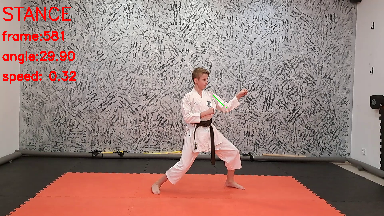

Обработано 581 кадров
Всего обработано 583 кадров


In [21]:
for file_name in file_names:
  print(f'Обработка файла {file_name}')
  df_video=mark_phase(df,file_name,reference_angles,show_all_charts=False)
  #Обновляем данные в основном датафрейме
  df.phase[df_video.index]=df_video.phase

  #Отображение результатов на видео
  #парамеры для построения пути к видеофайлу
  df1=df[df['filename']==file_name]
  correct=df1.correct.iloc[0]
  main_folder=df1.main_folder.iloc[0]
  folder=df1.folder.iloc[0]
  print(f'correct={correct} main_folder={main_folder} folder={folder}')

  VideoPathIn=f'/content/drive/MyDrive/internship/karate/dataset/{correct}/{main_folder}/{folder}/{file_name}.mp4'
  VideoPathOut=f'/content/{file_name} Marked_v2.mp4'

  #для визуализации угла получаем названия столбцов в датафрейме df1 с координатами
  dots=reference_angles[0][1:].split('_')
  dots

  mark_move(df_video,reference_angles,VideoPathIn, VideoPathOut,dots,df)

In [22]:
out_filename='dataset__all_features_phase.csv'
df.to_csv(os.path.join(data_path,out_filename), index=False)